# MAXIMUM LIKELIHOOD ESTIMATION

## Exponential Ornstein-Uhlenbeck procress
With $\Large \alpha$ the relaxation time towards the stationary value $\Large m$. $\Large \kappa$ accounts for the size of the fluctuations

$ \Large u(t)=ln\left( \frac{v}{<v>} \right) $

$ \Large du(t) = -\alpha[u(t)-m] + \kappa dW(t)$



## MLE Parameters:

$ \Large \hat{\beta_{1}} = e^{-\hat{\alpha}·\delta} $

$ \Large \hat{\beta_{2}} = \hat{m} $

$ \Large \hat{\beta_{3}} = \left( \frac{\hat{\kappa}^{2}}{2·\hat{\alpha}} \right) · \left( 1-e^{-2·\hat{\alpha}·\delta} \right) $

where $\delta =1$ in our data


### Computational estimation:
$ \Large \hat{\beta_{1}} = \frac{N\sum_{i=1}^{N}u_{i}u_{i-1} - \sum_{i=1}^{N}u_{i} \sum_{i=1}^{N}u_{i-1}}{N\sum_{i=1}^{N}u_{i-1}^{2}-\left( \sum_{i=1}^{N}u_{i-1} \right)^{2}} $

$ \Large \hat{\beta_{2}} = \frac{\sum_{i=1}^{N}\left[ u_{i}-\hat{\beta_{1}}u_{i-1}\right]}{N(1-\hat{\beta_{1}})} $

$ \Large \hat{\beta_{3}} = \frac{1}{N} \sum_{i=1}^{N} \left[ u_{i}-\hat{\beta_{1}}u_{i-1}-\hat{\beta_{2}}(1-\hat{\beta_{1}})\right]^{2}$

# INDEX

    1. MLE for each participant and average values
    
    2. MLE for the three most data-rich schools
        2.1- Box plot. Alpha
        2.2- Box plot. m
        2.3- Box plot. k^2
        2.4- Box plot. k^2/2·alpha
        
        
For the computation, we use the interpolated data. Then we have a temporal series uniformly separated by one second

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.optimize import curve_fit
from scipy.special import lpmn
import scipy
from scipy.stats import kurtosis, skew
from scipy.special import gamma
import scipy.special as sp
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy import stats
import glob
import os
from math import sin, cos, sqrt, atan2, radians

plt.style.use('tableau-colorblind10')

plt.style.library['tableau-colorblind10']


def getDistanceFromLatLonInM(lat1,lon1,lat2,lon2):
    """ Function that returns the distance in metres between 2 GPS locations in degrees (latitude and longitude).
    It is based in the Haversine formula (https://en.wikipedia.org/wiki/Haversine_formula) which takes into account the
    Earth's curvature. 
    
    Input:
        - 2 GPS coordinates: (latitude1,longitude1) of the first point and (latitude2,longitude2) of the second point. 
        
    Output:
        - Distance in metres between the two GPS locations.
    """
    
    R = 6371 # Radius of the earth in km
    dLat = radians(lat2-lat1)
    dLon = radians(lon2-lon1)
    rLat1 = radians(lat1)
    rLat2 = radians(lat2)
    a = sin(dLat/2) * sin(dLat/2) + cos(rLat1) * cos(rLat2) * sin(dLon/2) * sin(dLon/2) 
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    d = R * c # Distance in km
    e= d*1000 #distance in m
    
    return e

# 1. MLE for each participant and average values

EXPONENTIAL ORNSTEIN-UHLENBECK PROCESS

$u(t)=ln(v(t))$

$du(t)=[b-a·u(t)]dt + \sigma dW(t)$



MLE parameters:  $\alpha$, $\beta$, $V^{2}$

$\alpha= e^{-a·\delta}$

$\beta= b/a$

$V^{2}=  \left(\frac{\sigma^{2}}{2a}\right) · (1-e^{-2·a·\delta})$


Our equation is:   $du(t)=-\alpha[u(t)-m]+\kappa dW(t)$

Be careful not to confuse the parameters!!!!

In our case:

-The parameter "m" is: $m=\beta=b/a$

-The parameter "alpha" is: $\alpha=a=-log(\alpha)/\delta$    where alpha inside log is the one estimated by MLE (don't get confuse)

-The parameter "k" is: $\kappa=\sigma = \frac{\sqrt{2·a·V^{2}}}{1-e^{-2·a·\delta)}}$


In [4]:
all_files = glob.glob(os.path.join("*.csv")) #make list of paths (csv files for all individuals)

n_user=0
alphas=[]
k2s=[]
ms=[]
std_alphas=[]
std_k2s=[]
std_ms=[]
stds=[]
std_stds=[]

for file in all_files:   #loop over all csv files in the folder/directory   
    df = pd.read_csv(file)   #using pandas to read each csv file
    
    
    # LINEAR INTERPOLATION
    
    df2=df.copy() 

    if 'index' in df2:   # if the file has the column index, delete it
        del df2['index']

    df2['time'] = pd.to_datetime(df2['time'])   # Time to datetime format
    df2.index = df2['time']  # Then convert the column time into index

    del df2['time']  # delete column time
    del df2['nickname']
    del df2['At']
    del df2['d']
    del df2['v']

    # Resample time index every second and interpolate
    df2=df2.resample('1S').asfreq().interpolate()
    df2.reset_index(level=0, inplace=True)

    # We recalculate the time difference and the distance and the corresponding velocity after interpolating the data.
    At=[]
    distance=[]
    for i in range(1,len(df2['time'])):
        At.append((df2['time'][i]-df2['time'][i-1]).total_seconds())
        dist=getDistanceFromLatLonInM(df2['latitude'][i-1],df2['longitude'][i-1],df2['latitude'][i],df2['longitude'][i])
        distance.append(dist)

    At.insert(len(At), np.nan)
    distance.insert(len(distance), np.nan)

    df2['At']=At                # Insert the columns into the dataframe, calculate v (same as d if At=1s.)
    df2['d']=distance         
    df2['v']=df2['d']/df2['At']
    

    vel=df2['v'][:-1].tolist()         # Obtain the logarithm of each velocity vector as u=ln(v/<v>), for each user.
    
    mean_v=sum(vel)/len(vel)
    u=[]
    for i in range(len(vel)):
        v_log=np.log(vel[i]/mean_v)
        u.append(v_log)
        
    velocities = np.array(u)  #list to array


    vel2=[]
    vel_sum=0
    vel_sum2=0
    vel_square=[]
    for i in range(1,len(velocities)):               # MLE parameters. We calculate the sumation inside the parameters beta
        vel2.append(velocities[i]*velocities[i-1])  # u(i)·u(i-1)
        vel_square.append(velocities[i-1]**2)    # u(i-1)^2
        vel_sum=vel_sum+velocities[i]       # summation of u(i)
        vel_sum2=vel_sum2+velocities[i-1]   # summation of u(i-1)
    
    suma1=sum(vel2)   # summation of  u(i)·u(i-1)
    suma2=sum(vel_square)   # summation of u(i-1)^2 
    suma3=vel_sum2**2      # square of summation of u(i-1)
    
    # BETA 1
    numerador=(len(velocities)*suma1)-(vel_sum*vel_sum2)  # numerator and denominator 
    denominador=(len(velocities)*suma2)-(suma3)
    beta1=numerador/denominador  # Compute Beta 1
    
    # BETA 2  
    vel3=[]
    for i in range(1,len(velocities)):  
        vel3.append(velocities[i]-beta1*velocities[i-1])   # Calculation of u(i) - beta1*u(i-1)
    
    beta2=sum(vel3)/(len(velocities)*(1.-beta1)) # Compute Beta 2
    
    # BETA 3
    vel4=[]
    for i in range(1,len(velocities)):   # Calculation of u(i)-beta1*u(i-1)-beta2(1-beta1)^2
        vel4.append((velocities[i]-beta1*velocities[i-1]-beta2*(1.-beta1))**2)  

    beta3=sum(vel4)/len(velocities)  # Compute Beta 3
    
    
    
    # For each user, print the MLE parameters Beta 1, Beta2 and Beta 3 and then calculate the parameters alpha, m and k2
    # and sigma=k2/2alpha.  And their standard deviations.
    
    print(n_user,'-',file)
    print('')
    print('MLE parameters, beta1, beta2, beta3')
    print('')
    print('beta1=',beta1,'beta2=',beta2,'beta3=',beta3)

    delta=1   # Delta is 1 in our data (geo-locations separated uniformly by 1 second after linear interpolation)
    alpha=-np.log(beta1)/delta   # Compute alpha, m, k2 and sigma using beta1, beta2 and beta3.
    m=beta2
    k2=(2*alpha*beta3)/(1.-np.exp(-2*alpha))
    std=k2/(2.*alpha)
    
    std_alpha=np.sqrt(2*alpha/len(velocities))/np.sqrt(len(velocities))   # Standard deviations of alpha, m and k2.
    std_m=np.sqrt(k2/(len(velocities)*alpha**2))/np.sqrt(len(velocities))
    std_k2=np.sqrt((2*(k2**2))/len(velocities))/np.sqrt(len(velocities))
    
    aa=((1./(2.*alpha))**2)
    bb=std_k2**2
    cc=(-k2/(2.*(alpha**2)))**2
    dd=std_alpha**2
    std_std=np.sqrt((aa*bb)+(cc*dd))  # Standard devitation of sigma=k2/2alpha (by error propagation)
    
    
    print('')
    print('alpha, m, k^2, sigma')
    print('')

    print('alpha=',alpha, 'std_alpha=', std_alpha)
    print('m=', m, 'std_m', std_m)
    #print('v0=',np.exp(u0))
    print('k^2=',k2, 'std_k2', std_k2)
    print('sigma=',std, 'std_sigma', std_std)

    print('')
    print('------------------------------------------------')
    print('')
    print('')
    n_user=n_user+1
    
    alphas.append(alpha)
    k2s.append(k2)
    ms.append(m)
    stds.append(std)
    std_alphas.append(std_alpha)
    std_k2s.append(std_k2)
    std_ms.append(std_m)
    std_stds.append(std_std)


    
print('')

#We obtain the mean value of the parameters and standard devations of all the users
mean_all_alpha=sum(alphas)/len(alphas)
mean_all_m=sum(ms)/len(ms)
mean_all_k2=sum(k2s)/len(k2s)
mean_all_sigma=sum(stds)/len(stds)

mean_std_all_alpha=sum(std_alphas)/len(std_alphas)
mean_std_all_m=sum(std_ms)/len(std_ms)
mean_std_all_k2=sum(std_k2s)/len(std_k2s)
mean_std_all_sigma=sum(std_stds)/len(std_stds)

print('AVERAGE OVER ALL USERS')
print('')
print('<alpha>=', mean_all_alpha, '', '<std alpha>=',mean_std_all_alpha)
print('<m>=', mean_all_m, '', '<std m>=',mean_std_all_m)
print('<k2>=', mean_all_k2, '', '<std k2>=',mean_std_all_k2)
print('<std>=',mean_all_sigma,'','<std sigma>=',mean_std_all_sigma)


0 - 2018-11-05_sgv_0101_PEU.csv

MLE parameters, beta1, beta2, beta3

beta1= 0.8579325195386773 beta2= -0.2550301030082618 beta3= 0.20905772696029132

alpha, m, k^2, sigma

alpha= 0.1532298311434548 std_alpha= 0.0003394163026682833
m= -0.2550301030082618 std_m 0.0019713338531834592
k^2= 0.24272523379049138 std_k2 0.00021046310089312887
sigma= 0.7920299591117164 std_sigma 0.001884034792615625

------------------------------------------------


1 - 2018-11-05_sgv_0102_peu.csv

MLE parameters, beta1, beta2, beta3

beta1= 0.7151303813268627 beta2= -0.07986357855126439 beta3= 0.08571134866484036

alpha, m, k^2, sigma

alpha= 0.3352904014060427 std_alpha= 0.0016088211829416665
m= -0.07986357855126439 std_m 0.002009713650675861
k^2= 0.11763760416475176 std_k2 0.00032684615963628606
sigma= 0.175426441782165 std_sigma 0.0009726790753151271

------------------------------------------------


2 - 2018-11-05_sgv_0201_peu.csv

MLE parameters, beta1, beta2, beta3

beta1= 0.8065844317189484 beta2= -0

19 - 2018-11-05_sgv_2102_peu.csv

MLE parameters, beta1, beta2, beta3

beta1= 0.3573684616248382 beta2= -0.16582096541294614 beta3= 0.33531550246166614

alpha, m, k^2, sigma

alpha= 1.028987924065367 std_alpha= 0.007208867786030208
m= -0.16582096541294614 std_m 0.004343638798851231
k^2= 0.7911049762552672 std_k2 0.005622067269753991
sigma= 0.38440926164115596 std_sigma 0.003836103853772019

------------------------------------------------


20 - 2018-11-05_sgv_2103_peu.csv

MLE parameters, beta1, beta2, beta3

beta1= 0.22423813582741234 beta2= -0.10985028234096719 beta3= 0.22082305716055553

alpha, m, k^2, sigma

alpha= 1.4950466854521134 std_alpha= 0.00680782931205648
m= -0.10985028234096719 std_m 0.0021957300623177654
k^2= 0.6952401396208246 std_k2 0.0038709371439288754
sigma= 0.2325145249262162 std_sigma 0.0016724122117643496

------------------------------------------------


21 - 2018-11-05_sgv_23_peu.csv

MLE parameters, beta1, beta2, beta3

beta1= 0.8956522829501428 beta2= -0.09

39 - 2018-11-08_bel_15_peu.csv

MLE parameters, beta1, beta2, beta3

beta1= 0.9205454546979138 beta2= -0.2501242079335876 beta3= 0.09820724839411737

alpha, m, k^2, sigma

alpha= 0.0827888990850347 std_alpha= 0.0006408071166344001
m= -0.2501242079335876 std_m 0.006209481275624686
k^2= 0.10656198680128876 std_k2 0.00023732505034300047
sigma= 0.6435765421390377 std_sigma 0.005183550359512233

------------------------------------------------


40 - 2018-11-08_bel_2906_peu.csv

MLE parameters, beta1, beta2, beta3

beta1= 0.9157563443732275 beta2= -0.626246553584694 beta3= 0.28385850920160516

alpha, m, k^2, sigma

alpha= 0.08800494928471972 std_alpha= 0.0007003928822984104
m= -0.626246553584694 std_m 0.010554723177995553
k^2= 0.30957190067051565 std_k2 0.0007308861109480132
sigma= 1.758832333787087 std_sigma 0.0146007277609538

------------------------------------------------


41 - 2018-11-08_bel_4321_peu.csv

MLE parameters, beta1, beta2, beta3

beta1= 0.8398588111734259 beta2= -0.236755

59 - 2018-11-09_zaf_0029_peu.csv

MLE parameters, beta1, beta2, beta3

beta1= 0.8488800727357408 beta2= -0.538220253488164 beta3= 0.4581568371162585

alpha, m, k^2, sigma

alpha= 0.1638373597324443 std_alpha= 0.0004568466000508858
m= -0.538220253488164 std_m 0.0035706666211478798
k^2= 0.5373121123134053 std_k2 0.0006064437960582229
sigma= 1.6397728613024112 std_sigma 0.004932729473587547

------------------------------------------------


60 - 2018-11-09_zaf_0030_peu.csv

MLE parameters, beta1, beta2, beta3

beta1= 0.8587656771469547 beta2= -0.14895614764972376 beta3= 0.0976014627588706

alpha, m, k^2, sigma

alpha= 0.15225917983701057 std_alpha= 0.0014874173097341487
m= -0.14895614764972376 std_m 0.005956553682854273
k^2= 0.11321524526694662 std_k2 0.0004315647852396557
sigma= 0.37178462864485595 std_sigma 0.003898664500105573

------------------------------------------------


61 - 2018-11-09_zaf_0058_pe.csv

MLE parameters, beta1, beta2, beta3

beta1= 0.6495774946112133 beta2= -0.21

80 - 2018-11-16_ver_007_peu.csv

MLE parameters, beta1, beta2, beta3

beta1= 0.892164612311528 beta2= -0.11013201259111885 beta3= 0.055315181767955655

alpha, m, k^2, sigma

alpha= 0.11410462047793976 std_alpha= 0.0009312134672258198
m= -0.11013201259111885 std_m 0.004249208868684473
k^2= 0.06186675686260722 std_k2 0.00017055127995153582
sigma= 0.27109663308756254 std_sigma 0.002335248645475211

------------------------------------------------


81 - 2018-11-16_ver_045_peu.csv

MLE parameters, beta1, beta2, beta3

beta1= 0.7657325433244715 beta2= -0.09544521629301449 beta3= 0.0858189436565617

alpha, m, k^2, sigma

alpha= 0.2669223303629645 std_alpha= 0.0011524396552131323
m= -0.09544521629301449 std_m 0.0019665564905456115
k^2= 0.11075444979925621 std_k2 0.00024705117507772595
sigma= 0.20746568795621345 std_sigma 0.001008218267604438

------------------------------------------------


82 - 2018-11-16_ver_049_peu.csv

MLE parameters, beta1, beta2, beta3

beta1= 0.8880737834738855 beta2

# 2. MLE for the three most data-rich schools

We copy the code above for the MLE parameters but storing the parameters for each school.
Then we study the parameters for the three most data-rich schools (IFT, ZAF and SGV).

In [3]:
all_files = glob.glob(os.path.join("*.csv")) #make list of paths (csv files for all individuals)

alpha_ift=[]
m_ift=[]
k2_ift=[]
std_alpha_ift=[]
std_m_ift=[]
std_k2_ift=[]
std_ift=[]
std_std_ift=[]


alpha_ipc=[]
m_ipc=[]
k2_ipc=[]
std_alpha_ipc=[]
std_m_ipc=[]
std_k2_ipc=[]
std_ipc=[]
std_std_ipc=[]

alpha_zaf=[]
m_zaf=[]
k2_zaf=[]
std_alpha_zaf=[]
std_m_zaf=[]
std_k2_zaf=[]
std_zaf=[]
std_std_zaf=[]

alpha_mon=[]
m_mon=[]
k2_mon=[]
std_alpha_mon=[]
std_m_mon=[]
std_k2_mon=[]
std_mon=[]
std_std_mon=[]


alpha_ver=[]
m_ver=[]
k2_ver=[]
std_alpha_ver=[]
std_m_ver=[]
std_k2_ver=[]
std_ver=[]
std_std_ver=[]

alpha_vir=[]
m_vir=[]
k2_vir=[]
std_alpha_vir=[]
std_m_vir=[]
std_k2_vir=[]
std_vir=[]
std_std_vir=[]

alpha_bel=[]
m_bel=[]
k2_bel=[]
std_alpha_bel=[]
std_m_bel=[]
std_k2_bel=[]
std_bel=[]
std_std_bel=[]

alpha_san=[]
m_san=[]
k2_san=[]
std_alpha_san=[]
std_m_san=[]
std_k2_san=[]
std_san=[]
std_std_san=[]

alpha_sgv=[]
m_sgv=[]
k2_sgv=[]
std_alpha_sgv=[]
std_m_sgv=[]
std_k2_sgv=[]
std_sgv=[]
std_std_sgv=[]

for file in all_files:   #loop over all csv files in the folder/directory   
    df = pd.read_csv(file)   #using pandas to read each csv file
    
    # Linear interpolation
    df2=df.copy() 

    if 'index' in df2:   # if the file has the column index, delete it
        del df2['index']

    df2['time'] = pd.to_datetime(df2['time'])   # Time to datetime format
    df2.index = df2['time']  # Then convert the column time into index

    del df2['time']  # delete column time
    del df2['nickname']
    del df2['At']
    del df2['d']
    del df2['v']

    # Resample time index every second and interpolate
    df2=df2.resample('1S').asfreq().interpolate()
    df2.reset_index(level=0, inplace=True)

# We calculate the time difference and the distance and the corresponding instantaneous velocity.
    At=[]
    distance=[]
    for i in range(1,len(df2['time'])):
        At.append((df2['time'][i]-df2['time'][i-1]).total_seconds())
        dist=getDistanceFromLatLonInM(df2['latitude'][i-1],df2['longitude'][i-1],df2['latitude'][i],df2['longitude'][i])
        distance.append(dist)

    At.insert(len(At), np.nan)
    distance.insert(len(distance), np.nan)

    df2['At']=At                # Insert the columns into the dataframe, calculate v (same as d if At=1s.)
    df2['d']=distance           # Then get a list of non NaN velocities, and obtain the mean value and the pdf for each s
    df2['v']=df2['d']/df2['At']
    

    vel=df2['v'][:-1].tolist()
    
    mean_v=sum(vel)/len(vel)   # u=ln(v/<v>)
    u=[]
    for i in range(len(vel)):
        v_log=np.log(vel[i]/mean_v)
        u.append(v_log)

        
    velocities = np.array(u)  #list to array

    
    # MLE parameters: beta1, beta2, beta3. And then estimation of alpha, m, k2 and sigma and their standard deviations.
    vel2=[]
    vel_sum=0
    vel_sum2=0
    vel_square=[]
    for i in range(1,len(velocities)):
        vel2.append(velocities[i]*velocities[i-1])
        vel_square.append(velocities[i-1]**2)
        vel_sum=vel_sum+velocities[i]
        vel_sum2=vel_sum2+velocities[i-1]
    
    suma1=sum(vel2)
    suma2=sum(vel_square)
    suma3=vel_sum2**2

    numerador=(len(velocities)*suma1)-(vel_sum*vel_sum2)
    denominador=(len(velocities)*suma2)-(suma3)
    beta1=numerador/denominador
    

    vel3=[]
    for i in range(1,len(velocities)):
        vel3.append(velocities[i]-beta1*velocities[i-1])
    
    beta2=sum(vel3)/(len(velocities)*(1.-beta1))

    vel4=[]
    for i in range(1,len(velocities)):
        vel4.append((velocities[i]-beta1*velocities[i-1]-beta2*(1.-beta1))**2)

    beta3=sum(vel4)/len(velocities)
    
    delta=1
    alpha=-np.log(beta1)/delta
    m=beta2
    k2=(2*alpha*beta3)/(1.-np.exp(-2*alpha))
    std=k2/(2.*alpha)
    
    std_alpha=np.sqrt(2*alpha/len(velocities))/np.sqrt(len(velocities))
    std_m=np.sqrt(k2/(len(velocities)*alpha**2))/np.sqrt(len(velocities))
    std_k2=np.sqrt((2*(k2**2))/len(velocities))/np.sqrt(len(velocities))
    
    aa=((1./(2.*alpha))**2)
    bb=std_k2**2
    cc=(-k2/(2.*(alpha**2)))**2
    dd=std_alpha**2
    std_std=np.sqrt((aa*bb)+(cc*dd))

    
    # STORE THE VALUES IN A LIST FOR EACH SCHOOL (USING THE SCHOOL CODE IN THE FILE NAME)
    
    if ('ift') in file:
        alpha_ift.append(alpha)
        m_ift.append(m)
        k2_ift.append(k2)
        std_alpha_ift.append(std_alpha)
        std_m_ift.append(std_m)
        std_k2_ift.append(std_k2)
        std_ift.append(std)
        std_std_ift.append(std_std)

        
    if ('zaf') in file:
        alpha_zaf.append(alpha)
        m_zaf.append(m)
        k2_zaf.append(k2)
        std_alpha_zaf.append(std_alpha)
        std_m_zaf.append(std_m)
        std_k2_zaf.append(std_k2)
        std_zaf.append(std)
        std_std_zaf.append(std_std)
        
    if ('sgv') in file:
        alpha_sgv.append(alpha)
        m_sgv.append(m)
        k2_sgv.append(k2)
        std_alpha_sgv.append(std_alpha)
        std_m_sgv.append(std_m)
        std_k2_sgv.append(std_k2)
        std_sgv.append(std)
        std_std_sgv.append(std_std)


# Mean value and standard deviation of alpha, m, k2 and sigma for each school

print('IFT')
print('nº:', len(alpha_ift))
print('<alpha>=', sum(alpha_ift)/len(alpha_ift), '', '<std alpha>=',sum(std_alpha_ift)/len(std_alpha_ift))
print('<m>=', sum(m_ift)/len(m_ift), '', '<std m>=',sum(std_m_ift)/len(std_m_ift))
print('<k2>=', sum(k2_ift)/len(k2_ift), '', '<std k2>=',sum(std_k2_ift)/len(std_k2_ift))
print('<std>=', sum(std_ift)/len(std_ift), '', '<std std>=',sum(std_std_ift)/len(std_std_ift))
print('')
print('----------------------------------------')
print('')


print('ZAF')
print('nº:', len(alpha_zaf))
print('<alpha>=', sum(alpha_zaf)/len(alpha_zaf), '', '<std alpha>=',sum(std_alpha_zaf)/len(std_alpha_zaf))
print('<m>=', sum(m_zaf)/len(m_zaf), '', '<std m>=',sum(std_m_zaf)/len(std_m_zaf))
print('<k2>=', sum(k2_zaf)/len(k2_zaf), '', '<std k2>=',sum(std_k2_zaf)/len(std_k2_zaf))
print('<std>=', sum(std_zaf)/len(std_zaf), '', '<std std>=',sum(std_std_zaf)/len(std_std_zaf))
print('')
print('----------------------------------------')
print('')


print('SGV')
print('nº:', len(alpha_sgv))
print('<alpha>=', sum(alpha_sgv)/len(alpha_sgv), '', '<std alpha>=',sum(std_alpha_sgv)/len(std_alpha_sgv))
print('<m>=', sum(m_sgv)/len(m_sgv), '', '<std m>=',sum(std_m_sgv)/len(std_m_sgv))
print('<k2>=', sum(k2_sgv)/len(k2_sgv), '', '<std k2>=',sum(std_k2_sgv)/len(std_k2_sgv))
print('<std>=', sum(std_sgv)/len(std_sgv), '', '<std std>=',sum(std_std_sgv)/len(std_std_sgv))
print('')
print('----------------------------------------')
print('')




IFT
nº: 10
<alpha>= 0.43357233061792655  <std alpha>= 0.002690238707711535
<m>= -0.0994455309306627  <std m>= 0.0024490536815376753
<k2>= 0.19997939882178367  <std k2>= 0.0006486481403571505
<std>= 0.23667622984033562  <std std>= 0.0013444297045258579

----------------------------------------

ZAF
nº: 13
<alpha>= 0.4176488886039451  <std alpha>= 0.0026579771674241706
<m>= -0.23332638481453769  <std m>= 0.005238390924322874
<k2>= 0.35599067713879884  <std k2>= 0.0015798028383578575
<std>= 0.6266510504664983  <std std>= 0.004795910722701998

----------------------------------------

SGV
nº: 28
<alpha>= 0.3984500075495171  <std alpha>= 0.0021123392349151307
<m>= -0.12889136313446953  <std m>= 0.003196933588065378
<k2>= 0.21354058276556423  <std k2>= 0.0008462259095608726
<std>= 0.3304622007854154  <std std>= 0.0021312460493729626

----------------------------------------



## 2.1 - Box plot. $\alpha$

Box plot comparing the three-most data rich schools for the parameter alpha

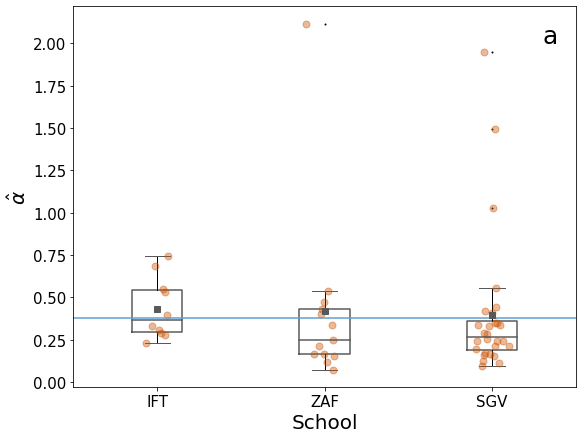

In [14]:
import numpy as np
import pylab as P

P.figure(figsize=(9,7))


values=[alpha_ift,alpha_zaf,alpha_sgv] 

names=['IFT','ZAF','SGV']



medianprops = dict(linewidth=1.5, linestyle='-', color='#595959')
meanprops=dict(marker="s",markerfacecolor="#595959", markeredgecolor="#595959")
boxprops = dict(linestyle='-', linewidth=1.5, color='#595959')
flierprops = dict(marker='o', markersize=1,
                  linestyle='none')
capprops = dict(color='#595959')

P.boxplot(values, labels=names,showmeans=True,boxprops=boxprops,meanprops=meanprops,medianprops=medianprops,flierprops=flierprops,capprops=capprops)
P.xlabel('School',fontsize=20)
P.ylabel(r'$\hat{\alpha}$',fontsize=20)
P.xticks(fontsize=15)
P.yticks(fontsize=15)


palette = ['#C85200', '#C85200', '#C85200']

for i in range(len(names)):
    y=values[i]
    x = np.random.normal(1+i, 0.04, size=len(y))
    P.plot(x, y, '.', ms=14,alpha=0.4,color=palette[i])
    
P.axhline(y=0.3806, color='#5F9ED1')

plt.text(3.3,2, 'a', fontsize = 25)

#plt.savefig('MLE_alpha.pdf',format='pdf', bbox_inches='tight')

## 2.2- Box plot. m
Box plot comparing the three-most data rich schools for the parameter m

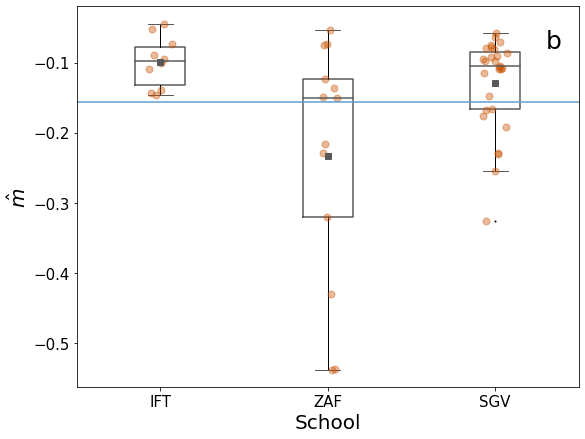

In [19]:
import numpy as np
import pylab as P

P.figure(figsize=(9,7))


values=[m_ift,m_zaf,m_sgv] 

names=['IFT','ZAF','SGV']


medianprops = dict(linewidth=1.5, linestyle='-', color='#595959')
meanprops=dict(marker="s",markerfacecolor="#595959", markeredgecolor="#595959")
boxprops = dict(linestyle='-', linewidth=1.5, color='#595959')
flierprops = dict(marker='o', markersize=1,
                  linestyle='none')
capprops = dict(color='#595959')

P.boxplot(values, labels=names,showmeans=True,boxprops=boxprops,meanprops=meanprops,medianprops=medianprops,flierprops=flierprops,capprops=capprops)
P.xlabel('School',fontsize=20)
P.ylabel(r'$\hat{m}$',fontsize=20)
P.xticks(fontsize=15)
P.yticks(fontsize=15)

palette = ['#C85200', '#C85200', '#C85200']

for i in range(len(names)):
    y=values[i]
    x = np.random.normal(1+i, 0.04, size=len(y))
    P.plot(x, y, '.', ms=14,alpha=0.4,color=palette[i])
    
    
P.axhline(y=-0.15606, color='#5F9ED1')

plt.text(3.3,-0.08, 'b', fontsize = 25)
#plt.savefig('MLE_m.pdf',format='pdf', bbox_inches='tight')

## 2.3- Box plot. $\kappa^2$

Box plot comparing the three-most data rich schools for the parameter k2

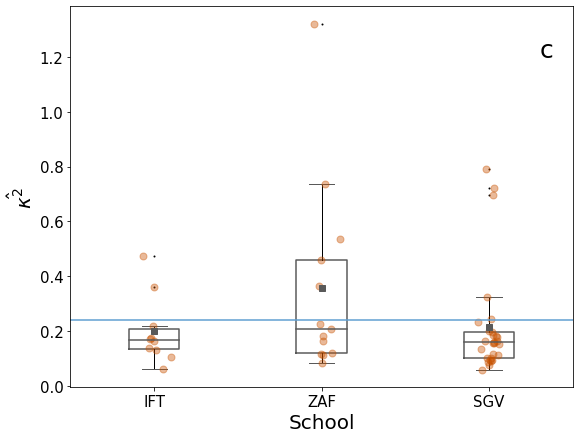

In [22]:
import numpy as np
import pylab as P

P.figure(figsize=(9,7))


values=[k2_ift,k2_zaf,k2_sgv] 

names=['IFT','ZAF','SGV']


medianprops = dict(linewidth=1.5, linestyle='-', color='#595959')
meanprops=dict(marker="s",markerfacecolor="#595959", markeredgecolor="#595959")
boxprops = dict(linestyle='-', linewidth=1.5, color='#595959')
flierprops = dict(marker='o', markersize=1,
                  linestyle='none')
capprops = dict(color='#595959')

P.boxplot(values, labels=names,showmeans=True,boxprops=boxprops,meanprops=meanprops,medianprops=medianprops,flierprops=flierprops,capprops=capprops)
P.xlabel('School',fontsize=20)
P.ylabel(r'$\hat{\kappa^{2}}$',fontsize=20)
P.xticks(fontsize=15)
P.yticks(fontsize=15)

palette = ['#C85200', '#C85200', '#C85200']

for i in range(len(names)):
    y=values[i]
    x = np.random.normal(1+i, 0.04, size=len(y))
    P.plot(x, y, '.', ms=14,alpha=0.4,color=palette[i])
    
P.axhline(y=0.23907, color='#5F9ED1')

plt.text(3.3,1.2, 'c', fontsize = 25)
#plt.savefig('MLE_k2.pdf',format='pdf', bbox_inches='tight')

## 2.4- Box plot. $\Large \frac{\kappa^{2}}{2\alpha}$

Box plot comparing the three-most data rich schools for the parameter sigma=k2/2alpha

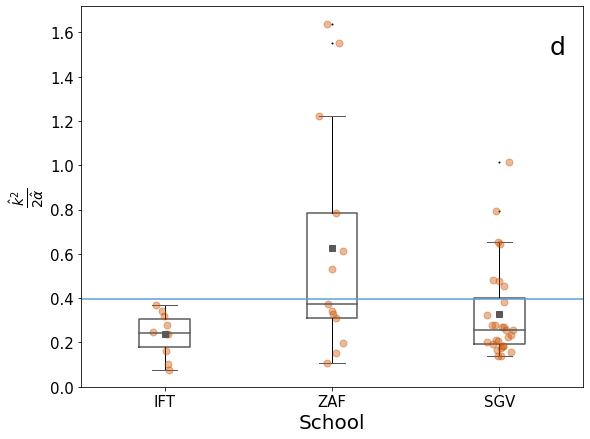

In [24]:
import numpy as np
import pylab as P

P.figure(figsize=(9,7))


values=[std_ift,std_zaf,std_sgv] 

names=['IFT','ZAF','SGV']


medianprops = dict(linewidth=1.5, linestyle='-', color='#595959')
meanprops=dict(marker="s",markerfacecolor="#595959", markeredgecolor="#595959")
boxprops = dict(linestyle='-', linewidth=1.5, color='#595959')
flierprops = dict(marker='o', markersize=1,
                  linestyle='none')
capprops = dict(color='#595959')

P.boxplot(values, labels=names,showmeans=True,boxprops=boxprops,meanprops=meanprops,medianprops=medianprops,flierprops=flierprops,capprops=capprops)
P.xlabel('School',fontsize=20)
P.ylabel(r'$\frac{\hat{k}^{2}}{2\hat{\alpha}}$',fontsize=20)
P.xticks(fontsize=15)
P.yticks(fontsize=15)

palette = ['#C85200', '#C85200', '#C85200']

for i in range(len(names)):
    y=values[i]
    x = np.random.normal(1+i, 0.04, size=len(y))
    P.plot(x, y, '.', ms=14,alpha=0.4,color=palette[i])
    
P.axhline(y=0.39786, color='#5F9ED1')

plt.text(3.3,1.5, 'd', fontsize = 25)
#plt.savefig('MLE_sigma.pdf',format='pdf', bbox_inches='tight')